---

# University of Liverpool

## COMP534 - Applied AI

---

This notebook is associated with Assignment 2. Use it to complete the assignment by following the instructions provided in each section. Each section includes a text cell outlining the requirements. For additional details, refer to Canvas.

If you are using Google Colab, you can use the cell below to download and unzip the data.
If you are running on your computer, you will need to do this yourself.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdulhasibuddin/uc-merced-land-use-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/uc-merced-land-use-dataset


In [ ]:
import shutil
import os

# Update this with your actual source path
source_path = path
destination_path = '/content/UCMerced_LandUse'

shutil.copytree(source_path, destination_path)

print(f"Dataset successfully copied to: {destination_path}")


Dataset successfully copied to: /content/UCMerced_LandUse


Use this first cell to import the necessary libraries.

In [ ]:
# General utilities
import os
import shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# TensorFlow / Keras (for deep learning pipeline)
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Torch and torchvision (optional, if you're mixing PyTorch tasks too)
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split


from torch.utils.data import Dataset, DataLoader


# 1. **Data Management**


In this part, you need to:

1.  define your experimental protocol (such as k-fold, cross validation, etc)
2.	create the dataloader to load the data; remember to include here any normalization, data augmentation, or other technique used to pre-process the data


Data Augmentation

In [ ]:
# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Input and output paths
#input_dataset_path = '/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images'
input_dataset_path = '/content/UCMerced_LandUse/UCMerced_LandUse/Images'
output_dataset_path = '/content/augmented_dataset'
trainval_path = os.path.join(output_dataset_path, 'trainval')
test_path = os.path.join(output_dataset_path, 'test')

# Ensure output directories exist
os.makedirs(trainval_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Augmentation transforms
augmentation_transforms = [
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    )
]

def augment_images_for_class(class_path, output_class_path, target_count=500):
    original_images = [f for f in os.listdir(class_path)
                       if f.lower().endswith('.tif')]

    if not original_images:
        print(f"Warning: No images found in {class_path}")
        return

    os.makedirs(output_class_path, exist_ok=True)

    for img_name in original_images:
        src_path = os.path.join(class_path, img_name)
        dst_path = os.path.join(output_class_path, img_name)
        shutil.copy(src_path, dst_path)

    attempts = 0
    max_attempts = 1000
    while len(os.listdir(output_class_path)) < target_count and attempts < max_attempts:
        try:
            src_img_name = np.random.choice(original_images)
            src_path = os.path.join(class_path, src_img_name)
            img = Image.open(src_path)

            transform = np.random.choice(augmentation_transforms)
            augmented_img = transform(img)

            base_name = os.path.splitext(src_img_name)[0]
            new_img_name = f"{base_name}_aug_{len(os.listdir(output_class_path))}.jpg"
            dst_path = os.path.join(output_class_path, new_img_name)
            augmented_img.save(dst_path)
            attempts = 0
        except Exception as e:
            print(f"Error augmenting image {src_img_name}: {e}")
            attempts += 1

    if len(os.listdir(output_class_path)) < target_count:
        print(f"Warning: Only {len(os.listdir(output_class_path))} images generated for {os.path.basename(output_class_path)}")

# Process each class
classes = os.listdir(input_dataset_path)
for class_name in classes:
    class_dir = os.path.join(input_dataset_path, class_name)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith('.tif')]

    trainval_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

    trainval_class_path = os.path.join(trainval_path, class_name)
    test_class_path = os.path.join(test_path, class_name)
    os.makedirs(trainval_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # Save test set (unaltered)
    for img_name in test_imgs:
        src = os.path.join(class_dir, img_name)
        dst = os.path.join(test_class_path, img_name)
        shutil.copy(src, dst)

    # Save and augment train/val set
    temp_class_path = os.path.join('/tmp', class_name)
    os.makedirs(temp_class_path, exist_ok=True)

    for img_name in trainval_imgs:
        shutil.copy(os.path.join(class_dir, img_name), os.path.join(temp_class_path, img_name))

    print(f"Processing class: {class_name}")
    augment_images_for_class(temp_class_path, trainval_class_path)
    shutil.rmtree(temp_class_path)

# Verify dataset
print("\nDataset Summary:")
for split in ['trainval', 'test']:
    print(f"\n{split.upper()} SET")
    for class_name in classes:
        path = os.path.join(output_dataset_path, split, class_name)
        num_images = len(os.listdir(path)) if os.path.exists(path) else 0
        print(f"{class_name}: {num_images} images")


Processing class: mobilehomepark
Processing class: beach
Processing class: parkinglot
Processing class: storagetanks
Processing class: airplane
Processing class: river
Processing class: mediumresidential
Processing class: runway
Processing class: buildings
Processing class: freeway
Processing class: overpass
Processing class: harbor
Processing class: agricultural
Processing class: sparseresidential
Processing class: forest
Processing class: intersection
Processing class: denseresidential
Processing class: chaparral
Processing class: golfcourse
Processing class: baseballdiamond
Processing class: tenniscourt

Dataset Summary:

TRAINVAL SET
mobilehomepark: 500 images
beach: 500 images
parkinglot: 500 images
storagetanks: 500 images
airplane: 500 images
river: 500 images
mediumresidential: 500 images
runway: 500 images
buildings: 500 images
freeway: 500 images
overpass: 500 images
harbor: 500 images
agricultural: 500 images
sparseresidential: 500 images
forest: 500 images
intersection: 500

Available classes: ['mobilehomepark', 'beach', 'parkinglot', 'storagetanks', 'airplane', 'river', 'mediumresidential', 'runway', 'buildings', 'freeway', 'overpass', 'harbor', 'agricultural', 'sparseresidential', 'forest', 'intersection', 'denseresidential', 'chaparral', 'golfcourse', 'baseballdiamond', 'tenniscourt']


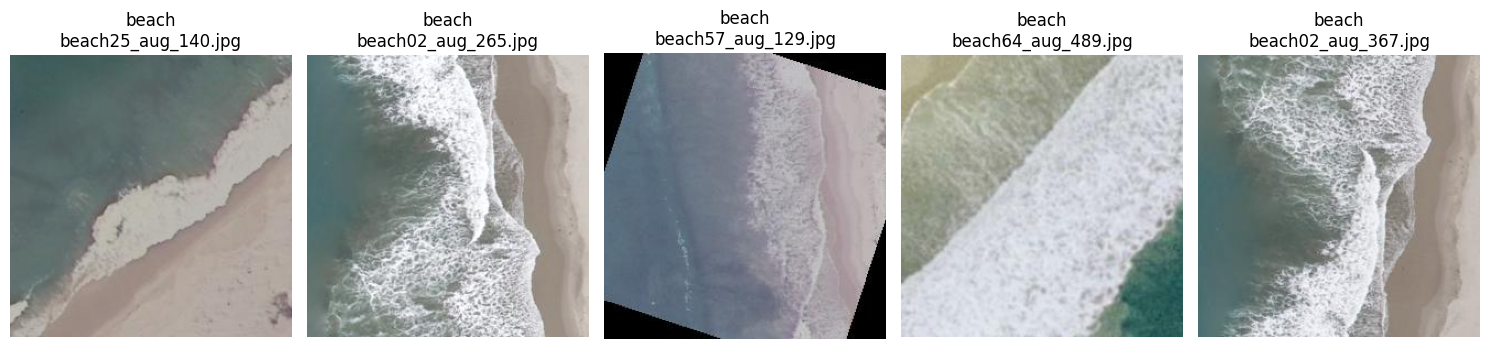

In [ ]:


def visualize_augmented_images(dataset_path, class_name=None, num_examples=4):
    """
    Visualize augmented images from the dataset

    Args:
    - dataset_path (str): Path to the augmented dataset
    - class_name (str, optional): Specific class to visualize. If None, shows first available class.
    - num_examples (int): Number of images to display
    """
    # If no class specified, choose first available class
    if class_name is None:
        classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
        if not classes:
            print("No classes found in the dataset!")
            return
        class_name = classes[0]

    # Full path to class
    class_path = os.path.join(dataset_path, class_name)

    # Get image files
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    # Check if enough images
    if len(image_files) < num_examples:
        print(f"Not enough images in class {class_name}. Available images: {len(image_files)}")
        num_examples = min(num_examples, len(image_files))

    # Create figure
    plt.figure(figsize=(15, 5))

    # Randomly select and display images
    for i in range(num_examples):
        # Select image
        img_path = os.path.join(class_path, image_files[i])

        # Open and display image
        plt.subplot(1, num_examples, i+1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"{class_name}\n{os.path.basename(img_path)}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Available classes
available_classes = os.listdir('/content/augmented_dataset/trainval')
print("Available classes:", available_classes)

# Example usage
# Visualize first 4 images of 'tenniscourt' class
visualize_augmented_images('/content/augmented_dataset/trainval', 'beach', 5)

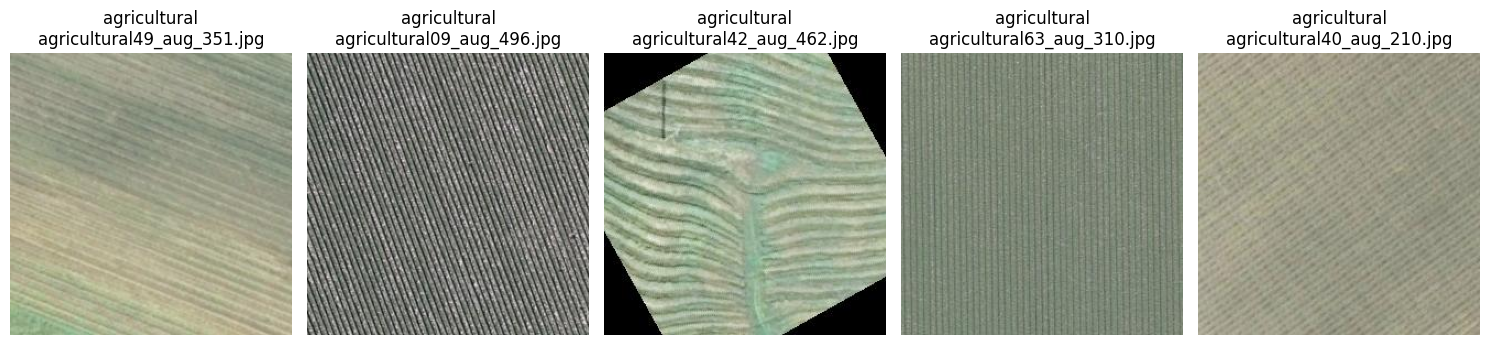

In [ ]:
visualize_augmented_images('/content/augmented_dataset/trainval', 'agricultural', 5)


In [ ]:
folder_path = '/content/augmented_dataset/trainval/beach'
num_images = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])

print(f"Number of images in 'beach': {num_images}")

Number of images in 'beach': 420


In [ ]:
from PIL import Image
import os

test_dir = '/content/augmented_dataset/test'

for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    for filename in os.listdir(class_path):
        if filename.lower().endswith('.tif'):
            tif_path = os.path.join(class_path, filename)
            jpg_path = os.path.splitext(tif_path)[0] + '.jpg'
            try:
                img = Image.open(tif_path)
                img.convert('RGB').save(jpg_path, 'JPEG')
                os.remove(tif_path)  # Remove the original .tif file
            except Exception as e:
                print(f"Failed to convert {tif_path}: {e}")


In [ ]:
folder_path = '/content/augmented_dataset/test/beach'
num_images = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])

print(f"Number of images in 'beach': {num_images}")

Number of images in 'beach': 20


In [ ]:
image_size = (224, 224)
batch_size = 32

# Load training/validation dataset from 'trainval' directory with 80-20 split
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/augmented_dataset/trainval',
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=42,
    label_mode='categorical'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/augmented_dataset/trainval',
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=42,
    label_mode='categorical'
)

# Load test dataset from 'test' directory (no validation split needed)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/augmented_dataset/test',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,  # Important for consistent evaluation
    label_mode='categorical'
)

# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to all datasets
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


Found 8820 files belonging to 21 classes.
Using 7056 files for training.
Found 8820 files belonging to 21 classes.
Using 1764 files for validation.
Found 420 files belonging to 21 classes.


---

# 2. **Neural Networks**

Here, you need to:

1.	propose your own Convolutional Neural Network (CNN) to tackle the problem;
2.	define at least one existing CNN (such as AlexNet, VGG, ResNet, DenseNet, etc) to tackle the problem;
3.	define the necessary components to train the networks (that is, loss function, optimizers, etc);
4.	train your proposed architecture from scratch using your training set;
5.	train the existing architecture using at least 2 different strategies (i.e., trained from scratch, fine-tuning, feature extractor, etc);
6.	for all training procedures, separately plot the loss and accuracy with respect to the epoch/iteration.



##Custom Model

In [ ]:
custom_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    # Conv Block 1
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 2
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 3
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 4
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 5
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 6
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Fully Connected
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(21, activation='softmax')
])


In [ ]:
custom_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,947,381 (15.06 MB)

 Trainable params: 3,945,365 (15.05 MB)

 Non-trainable params: 2,016 (7.88 KB)

In [ ]:
custom_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Epoch 1/50
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3240 - loss: 2.7716
Epoch 1: val_loss improved from inf to 12.90422, saving model to best_custom_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 44s 87ms/step - accuracy: 0.3250 - loss: 2.7650 - val_accuracy: 0.0448 - val_loss: 12.9042 - learning_rate: 1.0000e-04
Epoch 2/50
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6891 - loss: 0.9896
Epoch 2: val_loss improved from 12.90422 to 2.96857, saving model to best_custom_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6892 - loss: 0.9889 - val_accuracy: 0.2602 - val_loss: 2.9686 - learning_rate: 1.0000e-04
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8342 - loss: 0.5356
Epoch 3: val_loss improved from 2.96857 to 0.63908, saving model to best_custom_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.8342 - loss: 0.5355 - val_accuracy: 0.7999 - val_loss: 0.6391 - learning_rate: 1.0000e-04
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9016 - loss: 0.3217
Epoch 4: val_loss improved from 0.63908 to 0.39301, saving model to best_custom_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9016 - loss: 0.3216 - val_accuracy: 0.8747 - val_loss: 0.3930 - learning_rate: 1.0000e-04
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9438 - loss: 0.1828
Epoch 5: val_loss improved from 0.39301 to 0.33773, saving model to best_custom_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9438 - loss: 0.1827 - val_accuracy: 0.8963 - val_loss: 0.3377 - learning_rate: 1.0000e-04
Epoch 6/50
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9682 - loss: 0.1150
Epoch 6: val_loss improved from 0.33773 to 0.29150, saving model to best_custom_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9682 - loss: 0.1150 - val_accuracy: 0.9059 - val_loss: 0.2915 - learning_rate: 1.0000e-04
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9750 - loss: 0.0859
Epoch 7: val_loss did not improve from 0.29150
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9750 - loss: 0.0859 - val_accuracy: 0.9093 - val_loss: 0.3009 - learning_rate: 1.0000e-04
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9787 - loss: 0.0784
Epoch 8: val_loss improved from 0.29150 to 0.28904, saving model to best_custom_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9787 - loss: 0.0785 - val_accuracy: 0.9082 - val_loss: 0.2890 - learning_rate: 1.0000e-04
Epoch 9/50
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9777 - loss: 0.0718
Epoch 9: val_loss improved from 0.28904 to 0.28537, saving model to best_custom_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9777 - loss: 0.0718 - val_accuracy: 0.9093 - val_loss: 0.2854 - learning_rate: 1.0000e-04
Epoch 10/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9791 - loss: 0.0696
Epoch 10: val_loss did not improve from 0.28537
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9791 - loss: 0.0696 - val_accuracy: 0.9076 - val_loss: 0.3081 - learning_rate: 1.0000e-04
Epoch 11/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9855 - loss: 0.0471
Epoch 11: val_loss did not improve from 0.28537
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9855 - loss: 0.0472 - val_accuracy: 0.9036 - val_loss: 0.3132 - learning_rate: 1.0000e-04
Epoch 12/50
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9874 - loss: 0.0446
Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 12: val_loss did not improve from 0.28537
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9874 - loss: 0.0447

221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9894 - loss: 0.0334 - val_accuracy: 0.9382 - val_loss: 0.2135 - learning_rate: 5.0000e-05
Epoch 14/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9961 - loss: 0.0154
Epoch 14: val_loss improved from 0.21349 to 0.18461, saving model to best_custom_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9962 - loss: 0.0154 - val_accuracy: 0.9478 - val_loss: 0.1846 - learning_rate: 5.0000e-05
Epoch 15/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9974 - loss: 0.0096
Epoch 15: val_loss did not improve from 0.18461
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9974 - loss: 0.0096 - val_accuracy: 0.9433 - val_loss: 0.1908 - learning_rate: 5.0000e-05
Epoch 16/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9976 - loss: 0.0089
Epoch 16: val_loss did not improve from 0.18461
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9976 - loss: 0.0089 - val_accuracy: 0.9422 - val_loss: 0.1909 - learning_rate: 5.0000e-05
Epoch 17/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9973 - loss: 0.0118
Epoch 17: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 17: val_loss did not improve from 0.18461
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9973 - loss: 0.0118

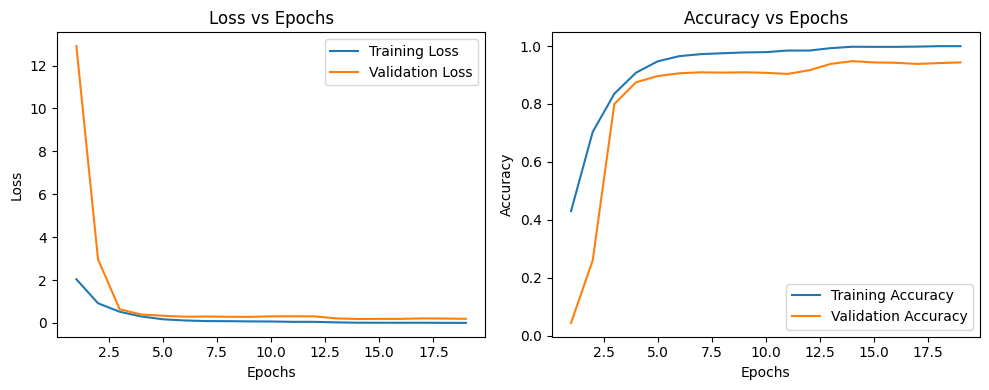

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    ModelCheckpoint('best_custom_model.h5', save_best_only=True, verbose=1)
]

history = custom_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

# Plotting Loss & Accuracy
epochs = range(1, len(history.history['loss']) + 1)

# Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## VGG Transfer Learning


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Load VGG16 without top classifier layers, using pretrained ImageNet weights
base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze base

# Add custom classification head
# Get class names from the 'train_dataset' object's parent directory
num_classes = len(os.listdir('/content/augmented_dataset/trainval'))
vgg_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Use num_classes
])

# Compile model
vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = vgg_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30
)


Epoch 1/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 54s 233ms/step - accuracy: 0.0769 - loss: 3.1279 - val_accuracy: 0.5085 - val_loss: 2.5312
Epoch 2/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 79s 223ms/step - accuracy: 0.3121 - loss: 2.4735 - val_accuracy: 0.6145 - val_loss: 2.0537
Epoch 3/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 47s 214ms/step - accuracy: 0.4616 - loss: 2.0302 - val_accuracy: 0.6633 - val_loss: 1.6945
Epoch 4/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 49s 224ms/step - accuracy: 0.5288 - loss: 1.7135 - val_accuracy: 0.7132 - val_loss: 1.4511
Epoch 5/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 48s 217ms/step - accuracy: 0.5953 - loss: 1.4950 - val_accuracy: 0.7330 - val_loss: 1.2824
Epoch 6/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 84s 225ms/step - accuracy: 0.6211 - loss: 1.3382 - val_accuracy: 0.7551 - val_loss: 1.1547
Epoch 7/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 47s 213ms/step - accuracy: 0.6688 - loss: 1.2282 - val_accuracy: 0.7534 - val_loss: 1.0591
Epoch 8/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 49s 221ms/step - accuracy: 0.6683 - loss: 1

In [ ]:
vgg_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 224, 224, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,947,381 (15.06 MB)

 Trainable params: 3,945,365 (15.05 MB)

 Non-trainable params: 2,016 (7.88 KB)

## Fine Tuning VGG by unfreezing top 4 layers


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Phase 1: Load base model (frozen)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

# Add custom head
num_classes = len(os.listdir('/content/augmented_dataset/trainval'))

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile & train head only
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Phase 2: Fine-tune top layers of VGG16
# Unfreeze last 4 convolutional layers (or fine-tune more as needed)
base_model.trainable = True

for layer in base_model.layers[:-4]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Optional: Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fine-tune the model
history_finetune = model.fit(train_dataset,
                             validation_data=val_dataset,
                             epochs=10,
                             callbacks=[early_stop])


---

# 3. **Evaluate models**

Here, you need to:

1.	evaluate the model (the best one you obtained in the above stage) on the testing dataset.


## Custom Model


In [ ]:
import tensorflow as tf

image_size = (224, 224)
batch_size = 32

# Load training/validation dataset from 'trainval' directory with 80-20 split
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/augmented_dataset/trainval',
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=42,
    label_mode='categorical'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/augmented_dataset/trainval',
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=42,
    label_mode='categorical'
)

# Load test dataset from 'test' directory (no validation split needed)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/augmented_dataset/test',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,  # Important for consistent evaluation
    label_mode='categorical'
)

# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to all datasets
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


Found 8820 files belonging to 21 classes.
Using 7056 files for training.
Found 8820 files belonging to 21 classes.
Using 1764 files for validation.
Found 420 files belonging to 21 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Epoch 1/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9838 - loss: 0.0781
Epoch 1: val_loss improved from inf to 0.52110, saving model to best_custom_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9838 - loss: 0.0781 - val_accuracy: 0.9393 - val_loss: 0.5211 - learning_rate: 0.0010
Epoch 2/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9902 - loss: 0.0395
Epoch 2: val_loss did not improve from 0.52110
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9902 - loss: 0.0395 - val_accuracy: 0.8855 - val_loss: 1.3518 - learning_rate: 0.0010
Epoch 3/200
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9853 - loss: 0.0964
Epoch 3: val_loss did not improve from 0.52110
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9853 - loss: 0.0963 - val_accuracy: 0.9133 - val_loss: 0.8584 - learning_rate: 0.0010
Epoch 4/200
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9863 - loss: 0.0639
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 0.52110
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9863 - loss: 0.0638 - val_accuracy:

221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.9942 - loss: 0.0268 - val_accuracy: 0.9705 - val_loss: 0.3920 - learning_rate: 5.0000e-04
Epoch 6/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9964 - loss: 0.0145
Epoch 6: val_loss did not improve from 0.39195
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9964 - loss: 0.0145 - val_accuracy: 0.9654 - val_loss: 0.4445 - learning_rate: 5.0000e-04
Epoch 7/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9975 - loss: 0.0114
Epoch 7: val_loss did not improve from 0.39195
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9975 - loss: 0.0114 - val_accuracy: 0.9700 - val_loss: 0.4235 - learning_rate: 5.0000e-04
Epoch 8/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9985 - loss: 0.0061
Epoch 8: val_loss improved from 0.39195 to 0.38650, saving model to best_custom_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.9985 - loss: 0.0062 - val_accuracy: 0.9677 - val_loss: 0.3865 - learning_rate: 5.0000e-04
Epoch 9/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9985 - loss: 0.0168
Epoch 9: val_loss did not improve from 0.38650
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9985 - loss: 0.0167 - val_accuracy: 0.9643 - val_loss: 0.4191 - learning_rate: 5.0000e-04
Epoch 10/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9980 - loss: 0.0096
Epoch 10: val_loss improved from 0.38650 to 0.38420, saving model to best_custom_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9980 - loss: 0.0096 - val_accuracy: 0.9705 - val_loss: 0.3842 - learning_rate: 5.0000e-04
Epoch 11/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9997 - loss: 0.0018
Epoch 11: val_loss improved from 0.38420 to 0.37881, saving model to best_custom_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 0.9745 - val_loss: 0.3788 - learning_rate: 5.0000e-04
Epoch 12/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9996 - loss: 0.0013
Epoch 12: val_loss did not improve from 0.37881
221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9654 - val_loss: 0.4035 - learning_rate: 5.0000e-04
Epoch 13/200
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9986 - loss: 0.0029
Epoch 13: val_loss did not improve from 0.37881
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9986 - loss: 0.0029 - val_accuracy: 0.9666 - val_loss: 0.4463 - learning_rate: 5.0000e-04
Epoch 14/200
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9990 - loss: 0.0044
Epoch 14: val_loss improved from 0.37881 to 0.37612, saving model to best_custom_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.9990 - loss: 0.0044 - val_accuracy: 0.9728 - val_loss: 0.3761 - learning_rate: 5.0000e-04
Epoch 15/200
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9987 - loss: 0.0048
Epoch 15: val_loss did not improve from 0.37612
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9987 - loss: 0.0048 - val_accuracy: 0.9677 - val_loss: 0.3793 - learning_rate: 5.0000e-04
Epoch 16/200
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9990 - loss: 0.0029
Epoch 16: val_loss did not improve from 0.37612
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9990 - loss: 0.0029 - val_accuracy: 0.9456 - val_loss: 0.5947 - learning_rate: 5.0000e-04
Epoch 17/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9976 - loss: 0.0216
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: val_loss did not improve from 0.37612
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9976 - loss: 0.

221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.9993 - loss: 0.0025 - val_accuracy: 0.9671 - val_loss: 0.3733 - learning_rate: 2.5000e-04
Epoch 20/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9991 - loss: 0.0047
Epoch 20: val_loss improved from 0.37330 to 0.31838, saving model to best_custom_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.9991 - loss: 0.0047 - val_accuracy: 0.9688 - val_loss: 0.3184 - learning_rate: 2.5000e-04
Epoch 21/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9992 - loss: 0.0029
Epoch 21: val_loss did not improve from 0.31838
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9992 - loss: 0.0029 - val_accuracy: 0.9688 - val_loss: 0.3720 - learning_rate: 2.5000e-04
Epoch 22/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9990 - loss: 0.0035
Epoch 22: val_loss improved from 0.31838 to 0.29243, saving model to best_custom_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.9990 - loss: 0.0035 - val_accuracy: 0.9705 - val_loss: 0.2924 - learning_rate: 2.5000e-04
Epoch 23/200
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9996 - loss: 0.0024
Epoch 23: val_loss did not improve from 0.29243
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9711 - val_loss: 0.4068 - learning_rate: 2.5000e-04
Epoch 24/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9997 - loss: 0.0012
Epoch 24: val_loss did not improve from 0.29243
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9308 - val_loss: 1.0265 - learning_rate: 2.5000e-04
Epoch 25/200
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9992 - loss: 0.0030
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 25: val_loss did not improve from 0.29243
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9992 - loss: 0

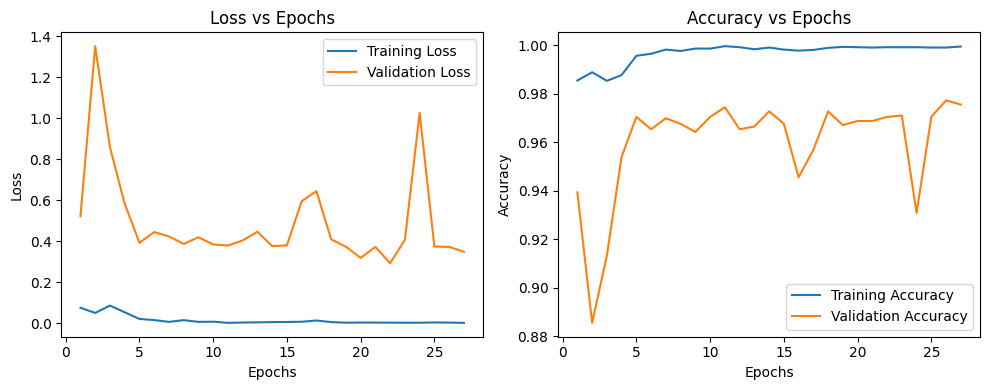

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    ModelCheckpoint('best_custom_model.h5', save_best_only=True, verbose=1)
]

history = custom_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=callbacks
)

# Plotting Loss & Accuracy
epochs = range(1, len(history.history['loss']) + 1)

# Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate model on test dataset
test_loss, test_accuracy = custom_model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9118 - loss: 0.9161

Test Loss: 1.2265
Test Accuracy: 0.8929


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    ModelCheckpoint('best_custom_model.h5', save_best_only=True, verbose=1)
]

history = custom_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3171 - loss: 2.7708
Epoch 1: val_loss improved from inf to 10.85017, saving model to best_custom_model.h5


210/210 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.3181 - loss: 2.7638 - val_accuracy: 0.0429 - val_loss: 10.8502 - learning_rate: 1.0000e-04
Epoch 2/30
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6940 - loss: 1.0051
Epoch 2: val_loss improved from 10.85017 to 3.84550, saving model to best_custom_model.h5


210/210 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.6942 - loss: 1.0043 - val_accuracy: 0.2036 - val_loss: 3.8455 - learning_rate: 1.0000e-04
Epoch 3/30
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8351 - loss: 0.5229
Epoch 3: val_loss improved from 3.84550 to 0.72010, saving model to best_custom_model.h5


210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8351 - loss: 0.5228 - val_accuracy: 0.7708 - val_loss: 0.7201 - learning_rate: 1.0000e-04
Epoch 4/30
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8991 - loss: 0.3283
Epoch 4: val_loss improved from 0.72010 to 0.39601, saving model to best_custom_model.h5


210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8991 - loss: 0.3282 - val_accuracy: 0.8690 - val_loss: 0.3960 - learning_rate: 1.0000e-04
Epoch 5/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9388 - loss: 0.2053
Epoch 5: val_loss did not improve from 0.39601
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9388 - loss: 0.2052 - val_accuracy: 0.8810 - val_loss: 0.4002 - learning_rate: 1.0000e-04
Epoch 6/30
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9599 - loss: 0.1280
Epoch 6: val_loss improved from 0.39601 to 0.37144, saving model to best_custom_model.h5


210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9599 - loss: 0.1281 - val_accuracy: 0.8833 - val_loss: 0.3714 - learning_rate: 1.0000e-04
Epoch 7/30
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9667 - loss: 0.0947
Epoch 7: val_loss improved from 0.37144 to 0.35811, saving model to best_custom_model.h5


210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9667 - loss: 0.0947 - val_accuracy: 0.9000 - val_loss: 0.3581 - learning_rate: 1.0000e-04
Epoch 8/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9775 - loss: 0.0753
Epoch 8: val_loss did not improve from 0.35811
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9774 - loss: 0.0754 - val_accuracy: 0.8732 - val_loss: 0.4143 - learning_rate: 1.0000e-04
Epoch 9/30
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9804 - loss: 0.0715
Epoch 9: val_loss improved from 0.35811 to 0.31519, saving model to best_custom_model.h5


210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9804 - loss: 0.0715 - val_accuracy: 0.9024 - val_loss: 0.3152 - learning_rate: 1.0000e-04
Epoch 10/30
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9810 - loss: 0.0613
Epoch 10: val_loss improved from 0.31519 to 0.31367, saving model to best_custom_model.h5


210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9810 - loss: 0.0613 - val_accuracy: 0.8982 - val_loss: 0.3137 - learning_rate: 1.0000e-04
Epoch 11/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9814 - loss: 0.0590
Epoch 11: val_loss improved from 0.31367 to 0.30189, saving model to best_custom_model.h5


210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.9814 - loss: 0.0590 - val_accuracy: 0.9006 - val_loss: 0.3019 - learning_rate: 1.0000e-04
Epoch 12/30
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9918 - loss: 0.0303
Epoch 12: val_loss did not improve from 0.30189
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9918 - loss: 0.0303 - val_accuracy: 0.8988 - val_loss: 0.3576 - learning_rate: 1.0000e-04
Epoch 13/30
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9878 - loss: 0.0415
Epoch 13: val_loss did not improve from 0.30189
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9878 - loss: 0.0415 - val_accuracy: 0.8988 - val_loss: 0.3498 - learning_rate: 1.0000e-04
Epoch 14/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9877 - loss: 0.0489
Epoch 14: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 14: val_loss did not improve from 0.30189
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9877 - loss: 0.048

210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9880 - loss: 0.0395 - val_accuracy: 0.9179 - val_loss: 0.2798 - learning_rate: 5.0000e-05
Epoch 16/30
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9974 - loss: 0.0097
Epoch 16: val_loss improved from 0.27979 to 0.25628, saving model to best_custom_model.h5


210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9974 - loss: 0.0097 - val_accuracy: 0.9280 - val_loss: 0.2563 - learning_rate: 5.0000e-05
Epoch 17/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9979 - loss: 0.0077
Epoch 17: val_loss improved from 0.25628 to 0.23342, saving model to best_custom_model.h5


210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9979 - loss: 0.0077 - val_accuracy: 0.9315 - val_loss: 0.2334 - learning_rate: 5.0000e-05
Epoch 18/30
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9976 - loss: 0.0100
Epoch 18: val_loss did not improve from 0.23342
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9976 - loss: 0.0100 - val_accuracy: 0.9274 - val_loss: 0.2579 - learning_rate: 5.0000e-05
Epoch 19/30
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9986 - loss: 0.0051
Epoch 19: val_loss did not improve from 0.23342
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9986 - loss: 0.0052 - val_accuracy: 0.9208 - val_loss: 0.2560 - learning_rate: 5.0000e-05
Epoch 20/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9991 - loss: 0.0049
Epoch 20: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 20: val_loss did not improve from 0.23342
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9991 - loss: 0.0049

In [ ]:
val_loss, val_accuracy = custom_model.evaluate(val_dataset)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9322 - loss: 0.2228

Validation Loss: 0.2334
Validation Accuracy: 0.9315
